In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ < '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = './output_pb_image_tensor/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './train/data/pascal_label_map_check.pbtxt'
NUM_CLASSES = 9

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
PATH_TO_TEST_IMAGES_DIR = './testimages'
TEST_IMAGE_PATH = [os.path.join(PATH_TO_TEST_IMAGES_DIR, img) for img in os.listdir(PATH_TO_TEST_IMAGES_DIR) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [203]:
import fnmatch
TEST_IMAGE_PATH_ = [os.path.join(PATH_TO_TEST_IMAGES_DIR, img)\
                    for img in fnmatch.filter(os.listdir(PATH_TO_TEST_IMAGES_DIR),'*.jpg') ]


In [204]:
TEST_IMAGE_PATH_

['./testimages/20171202_132416.jpg', './testimages/20171202_132406.jpg']

In [9]:
def generate_bounding_boxes(boxes, classes, category_index):
    """
    Pack bounding boxes with their class categories into a dict
    """
    bb_dict = {}
    for k, v in zip(np.squeeze(classes), np.squeeze(boxes)):
        if category_index[k]['name'] not in bb_dict.keys():
            #print ("iter")
            bb_dict[category_index[k]['name']] = list(v)
            
    return bb_dict

In [97]:
def create_image_parts_single_image(image_path, bb_dict):
    """
    Using normalised bounding box dictionary, generate boxes and divide image into segments
    and saving them into it's named folder
    """
    im = Image.open(image_path)
    im_width, im_height = im.size
    
    for k in bb_dict.keys():
        y_min = bb_dict[k][0]
        x_min = bb_dict[k][1]
        y_max = bb_dict[k][2]
        x_max = bb_dict[k][3]

        
        if k!='For/Memo':
            
            #Cropping
            crop_rectangle = (x_min*im_width, y_min*im_height, x_max*im_width, y_max*im_height)
            cropped_im = im.crop(crop_rectangle)
            
            image_folder_name = image_path.split('/')[-1].split('.')[0]
            
            if image_folder_name not in os.listdir('imageparts'):
                os.mkdir('imageparts/{}'.format(image_folder_name))
            #print k
            #print image_folder_name
            
            #Saving
            cropped_im.save('imageparts/{}/{}.jpg'.format(image_folder_name,k))
            print 'imageparts/{}/{}.jpg'.format(image_folder_name,k)


In [199]:
def predict_boxes():
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in TEST_IMAGE_PATHS:
                  image = Image.open(image_path)
                  # the array based representation of the image will be used later in order to prepare the
                  # result image with boxes and labels on it.
                  image_np = load_image_into_numpy_array(image)
                  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                  image_np_expanded = np.expand_dims(image_np, axis=0)
                  # Actual detection.
                  (boxes, scores, classes, num) = sess.run(
                      [detection_boxes, detection_scores, detection_classes, num_detections],
                      feed_dict={image_tensor: image_np_expanded})
                  # Visualization of the results of a detection.
                  vis_util.visualize_boxes_and_labels_on_image_array(
                      image_np,
                      np.array(np.squeeze(boxes)),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,
                      line_thickness=8)

                  bb_dict = generate_bounding_boxes(boxes,classes,category_index)
                  create_image_parts_single_image(image_path, bb_dict)

                  plt.figure(figsize=IMAGE_SIZE)
                  plt.imshow(image_np)
                  if 'predictions' not in os.listdir('testimages'):
                      os.mkdir('testimages/predictions/')
                  plt.imsave('testimages/predictions/{}'.format(image_path.split('/')[-1]), image_np)

imageparts/20171202_132416/Check#.jpg
imageparts/20171202_132416/Acc#.jpg
imageparts/20171202_132416/Amount.jpg
imageparts/20171202_132416/PayTo.jpg
imageparts/20171202_132416/Words.jpg
imageparts/20171202_132416/Signature.jpg
imageparts/20171202_132416/Date.jpg
imageparts/20171202_132416/Rtn#.jpg
imageparts/20171202_132406/Check#.jpg
imageparts/20171202_132406/Acc#.jpg
imageparts/20171202_132406/Amount.jpg
imageparts/20171202_132406/PayTo.jpg
imageparts/20171202_132406/Words.jpg
imageparts/20171202_132406/Signature.jpg
imageparts/20171202_132406/Date.jpg
imageparts/20171202_132406/Rtn#.jpg


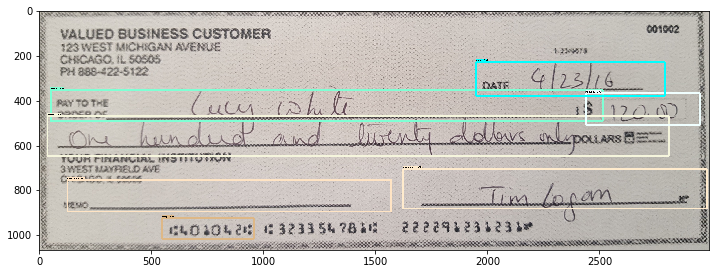

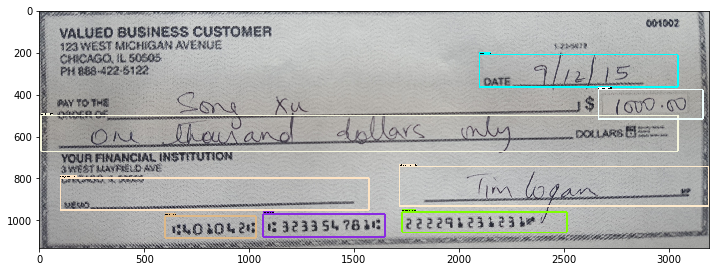

In [200]:
predict_boxes()

In [81]:
import io
import os

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
# Instantiates a client
client = vision.ImageAnnotatorClient()

In [82]:
#Performing OCR
def OCR(image_path):
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

        image = types.Image(content=content)

        response = client.document_text_detection(image=image)
        texts = response.text_annotations
        return texts[0].description

In [115]:
import datetime
from tqdm import tqdm
def calculate_data(sno, imageparts_dir, image_dir=None):
    """
    Calculate row data for each field in the big query schema using the image parts and applying ocr.
    """
    ROWS = []
    sno = sno
    break_flag = 0
    for img_dir in tqdm(os.listdir(imageparts_dir)):
        sno +=1
        if image_dir:
            img_dir = image_dir
            break_flag = 1
        BASE_DIR = os.path.join(imageparts_dir, img_dir)
        
        accno = None 
        rtn = None
        amount = None
        date = None
        payto = None
        consumed = None
        consumed_time = None
        match_score = None 
        mark_review = None 
        inference_priority = None
        train = 'False'
        fraud = None
        
        for img_path in os.listdir(BASE_DIR):
            try:
                if img_path == 'Acc#.jpg':
                          accno = OCR(os.path.join(BASE_DIR,img_path))
                          if accno != None:
                            accno = ''.join([e for e in accno.encode('utf-8') if e.isdigit()])
                          accno = None if accno == '' else accno
                          #print "ok"
                elif img_path == 'Date.jpg':
                          pass
                          #date = OCR(os.path.join(BASE_DIR,img_path))
                          #print "ok"
                elif img_path == 'Rtn#.jpg':
                          rtn = OCR(os.path.join(BASE_DIR,img_path))
                          #print "ok"
                            
                elif img_path == 'PayTo.jpg':
                          payto = OCR(os.path.join(BASE_DIR,img_path))
                          #print "payto "+ payto
                elif img_path == 'Amount.jpg':
                         amount = OCR(os.path.join(BASE_DIR,img_path))
                         if amount != None:
                            amount = ''.join([e for e in amount.encode('utf-8') if e.isdigit()])
                         amount = None if amount == '' else amount                     
            except:
                print "err"
                pass
        
        created_at = str(datetime.date.today())
        img_name = 'test_images/{}.jpg'.format(img_dir)
        xml_name = None#'labels/{}.xml'.format(img_dir)
            
        row_tuple = [sno, created_at, img_name, xml_name, accno, rtn, date, payto, amount, fraud,\
                             consumed, consumed_time, match_score, mark_review, inference_priority, train]
        ROWS.append(row_tuple)
        if break_flag == 1:
            break
    return ROWS

In [116]:
#Extracted rows for pushing into bigquery
ROWS = calculate_data(36,'imageparts')

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


In [198]:
image_path

'./testimages/20171202_132406.jpg'

In [117]:
ROWS

[[37,
  '2018-01-04',
  'test_images/20171202_132406.jpg',
  None,
  u'IC 3233 54 781\n',
  u'\u05d9\u05d5\u05e1 \u05e1\u05e0192\n',
  None,
  u'BAY \u03a4\u03bf THE\n59\n\u03b3X\n\u03c7\u03b7\u03bc\u03ad\u03bd\u03b1 \u039a\n',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  'False'],
 [38,
  '2018-01-04',
  'test_images/20171202_132416.jpg',
  None,
  u'1:323354 7811\n',
  u'12 \u1290\u12d0\u12e9 \u12d0\u1290\u1362\n',
  None,
  u'PAY TO THE\nORDER OF\nuM.\nU$\n',
  '120',
  None,
  None,
  None,
  None,
  None,
  None,
  'False']]

In [207]:
#Code to query for same accno and rtn no
def query_sign(accno,rtn):
    query = 'SELECT * from `demo.srlogs` WHERE rtno = \'{}\' and accno = \'{}\''.format(rtn, accno)
    client = bigquery.Client()
    query_job = client.query(query)

    # Print the results.
    for row in query_job.result():  # Waits for job to complete.
        #print "h"
        if row:
            return row
        else:
            return False
            
def match_query(ROWS):
    """
    Function to match accno and rtno of images in bigquery
    """
    for row in ROWS:
        if query_sign(row[4],row[5]):
            #Code 
            
            result = match_signatures(sign1_path, sign2_path)
            #Code
        else:
            push_into_bigquery(list(row))

In [102]:
import numpy as np
sys.path.append("./sigver_wiwd/")
# Functions to load and pre-process the images:
from scipy.misc import imread, imsave
from preprocess.normalize import normalize_image, resize_image, crop_center, preprocess_signature

# Functions to load the CNN model
import tensorflow as tf
import tf_signet
from tf_cnn_model import TF_CNNModel

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'



In [205]:
def extract_signature(image_path):
    """
    Function to extract features of signature for matching"""
    sys.path.append("./sigver_wiwd/")
    
    signature = imread(image_path, mode='L')
       
    canvas_size = (952, 1360)
    processed_signature = preprocess_signature(signature, canvas_size)
    
    # Path to the learned weights
    model_weight_path = './sigver_wiwd/models_cnn/signet.pkl'
    
    # Instantiate the model
    model = TF_CNNModel(tf_signet, model_weight_path)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    features = model.get_feature_vector(sess, processed_signature)
    return features

In [110]:
from sklearn.metrics.pairwise import euclidean_distances
def match_signatures(sign1_path, sign2_path):
    """
    Function to compute euclidean distance b/w two signs
    """
    
    sign1 = extract_signature(sign1_path, source)
    sign2 = extract_signature(sign2_path)
    
    return euclidean_distances(sign1, sign2)
    

In [20]:
def push_into_bigquery(ROWS):
    #Creating bigquery client
    from google.cloud import bigquery
    bigquery_client = bigquery.Client()

    #dataset and table id
    dataset_id = 'demo'
    table_id = 'srlogs'

    #dataset and table ref
    dataset_ref = bigquery_client.dataset(dataset_id)
    dataset = bigquery.Dataset(dataset_ref)

    table_ref = dataset.table('srlogs')
    table = bigquery_client.get_table(table_ref)
    
    #pushing into bigquery and store errors 
    errors = bigquery_client.create_rows(table, ROWS)

    if not errors:
        print('Loaded {} row(s) into {}:{}'.format(len(ROWS),dataset_id, table_id))
    else:
        print('Errors:')
        print(errors)

In [196]:
def query_sign(accno,rtn):
    query = "SELECT * from `demo.srlogs` WHERE accno = \'{}\' ".format(str(accno.encode('utf-8')))
    client = bigquery.Client() 
    query_job = client.query(query)

    # Print the results.
    for row in query_job.result():  # Waits for job to complete.
        #print "h"
        if row:
            return row
        else:
            return False
            

In [197]:
a = query_sign(rows[0][4], rows[0][5])

BadRequest: 400 Syntax error: Unclosed string literal at [1:43]

In [59]:
accno = '1955E2E200'
rtn = '1223 56 780:'
query = 'SELECT * from `demo.srlogs` WHERE rtno = \'{}\' and accno = \'{}\''.format(rtn, accno)
print query

SELECT * from `demo.srlogs` WHERE rtno = '1223 56 780:' and accno = '1955E2E200'


In [175]:
sno = '63'
query = 'SELECT * from `demo.srlogs` WHERE sno = \'{}\''.format(sno)
client = bigquery.Client()
query_job = client.query(query)

rows=[]
# Print the results.
for row in query_job.result():  # Waits for job to complete.
    #print "h"
    if row:
        print True
        rows.append(row)
    else:
        print False

True


In [147]:
a = rows[0][5]
a

u'123456780:\n'

In [181]:
query = "SELECT * from `demo.srlogs` WHERE accno = \'{}\'".format(accno.encode('utf-8'))

In [176]:
accno = rows[0][4]
rtn = rows[0][5]

In [182]:
query

"SELECT * from `demo.srlogs` WHERE accno = '1955E35 000\n'"

In [187]:
query[1:43]

"ELECT * from `demo.srlogs` WHERE accno = '"